## High Fis Values post HWE Filtering

Ater running batch 6 of the stacks pipeline, I have quite a few loci that have Fis values of 1.0 even after HWE filtering. I'm going to try to understand why this is happening, and if I needed to fix my filtering. 

In this notebook: 

1. The plot that led to this exploration, which shows Fis values by locus by population
2. Examples from the original genepop output, to look at why "NAs" are showing up in my parsed file that I am using to filter for Hardy Weinberg equilibrium. 
3. Identify "loci of interest" that have Fis values equal to 1.0. At these "loci of interest," is there only one population with an Fis value equal to 1.0, or several populations?
4. Double check manually to make sure that some of the loci identified as out of HWE were not accidentally kept in the filtered file.


<br>
#### 7/25/2017

<br>

### ONE: How many haplotypes have Fis == 1.0? The plot that started this exploration

In [78]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses'

The parsed genepop output was created in [this notebook](https://github.com/mfisher5/PCod-Korea-repo/blob/master/notebooks/Stacks%20batch%206.30%20-%20data%20visualization.ipynb). The genepop file run through was `batch_6_filteredMAF_filteredLoci_30filteredIndivids_filteredHWE_noreps.txt`

In [79]:
## Get population codes ##
fisfile = open("batch_6_30_INFgenepop_parsed_output.txt", "r")

fisfile.readline()

pop_codes = []

for line in fisfile:
    if line.strip().split()[0] not in pop_codes:
        pop_codes.append(line.strip().split()[0])
fisfile.close()

In [80]:
# create list of lists containing fis values #

fisfile = open("batch_6_30_INFgenepop_parsed_output.txt", "r")

lines = fisfile.readlines() # save all lines in file to variable
fisfile.close()
headerline = lines[0] # get header line
restlines = lines[1:] # get rest of lines

fis_sets = []
total_count = 0
pop_index = 0

snp_all_fis_gen = []
for pop in pop_codes:
    pop_fis = [] #create empty list
    for line in restlines:
        linelist = line.strip().split()
        if linelist[0] == pop: #if the population for that line matches pop we are interested in
            snp_fis = float(linelist[4])
            pop_fis.append(snp_fis) #append the snp fis to the pop specific fis list
            snp_all_fis_gen.append(snp_fis) #append the snp fis to the overall fis list
            total_count += 1
    pop_index += 1
    fis_sets.append(pop_fis)

print "Total SNPs counted: " + str(total_count)

Total SNPs counted: 47284


In [81]:
#import plotting packages
import matplotlib.pyplot as plt
import numpy as np

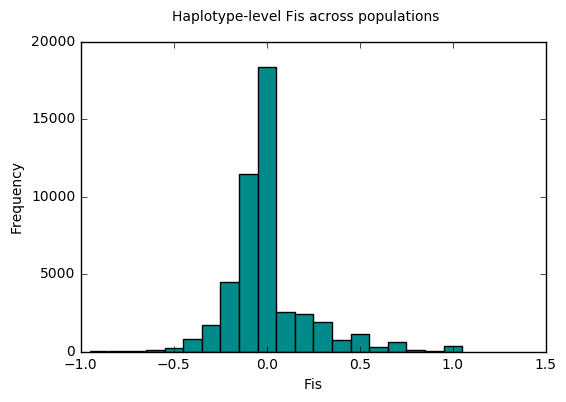

In [82]:
plt.hist(snp_all_fis_gen, bins = np.arange(-1, 1.1, .1)+0.05, color = "darkcyan")
plt.suptitle("Haplotype-level Fis across populations")
plt.xlabel("Fis")
plt.ylabel("Frequency")
plt.show()

In [83]:
plt.close()

In [84]:
#find all of the fis values that are equal to 1.0
fis_equal_one = [i for i in snp_all_fis_gen if float(i) == 1.0]

In [85]:
print len(fis_equal_one)

358


So there are **358 haplotypes** (across loci, across populations) that have an Fis value equal to 1.0


<br>
<br>
<br>


### TWO: Look into the original `.txt.P` GENEPOP output file

**Hypothesis: Some of the "NAs" that are in the parsed file that I am using for filtering might be arising from pvalues that are listed as "highly significant" instead of just 0.0. These loci are therefore not being filtered out, but they should be.**

In [1]:
pwd

u'/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/notebooks'

In [2]:
cd ../stacks_b6_wgenome/

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/stacks_b6_wgenome


Dan's script parses out p-values using the "by population" chart at the end of the formatted genepop output file, `batch_6_filteredMAF_filteredLoci_30filteredIndivids.txt.P`. 

**First Few lines of the original genepop output that is providing the data for the parsed file**

In [ ]:
==========================================
     Results by population
==========================================


 Pop : PO031715_24
-----------------------------------------
                             Fis estimates
                            ---------------
locus       P-val   S.E.    W&C     R&H     Steps 
----------- ------- ------- ------- ------- ------
10000       0.6780    -     -0.1222 -0.1239     10 matrices
10006        No information. 
10009        No information. 
10017       0.3156    -      0.2105  0.2147      4 matrices
10019       1.0000    -     -0.0169 -0.0172      2 matrices
10023        No information. 
10024       0.0679    -     -0.3636 -0.3674     14 matrices
10025       0.6987    -     -0.1111 -0.1127     12 matrices
10029        No information. 
10031       1.0000    -     -0.0345 -0.0350      2 matrices
10037        No information. 
1004        0.5532    -     -0.2000 -0.2026      6 matrices

**So the "NAs" are coming from the "No Information" designations. Looking at the chart for locus 10006 to see where the "No information" designation comes from:**

In [ ]:
Locus "10006"
-----------------------------------------
                             Fis estimates
                            ---------------
POP         P-val   S.E.    W&C     R&H     Steps 
----------- ------- ------- ------- ------- ------
PO031715_2   - 
GEO012315_   - 
NA021015_3   - 
YS121316_3   - 
JUK07_37.1  0.1976    -      0.3514  0.3611      3 matrices
JB021108_0   - 
JB021108_4  0.0196    -      1.0000  1.0400      2 matrices
BOR07_22     - 
GEO020414_   - 

All (Fisher's method):
 Chi2:    11.1070
 Df   :    4.0000
 Prob :    0.0254

So that locus is not present in those populations (to be retained, loci only have to be present in >5% of individuals in at least one population). 


<br>
<br>

### THREE: Of the loci with Fis values equal to 1.0, how many populations have an Fis = to 1.0?**

Basically, do the Fis values of 1.0 come from a few loci with a lot of populations' Fis equal to 1.0, or a large number of loci with only one population's Fis equal to 1.0?


In [88]:
# get a list of loci that have at least one population in which the p value is less than 0.001
#---- this assumes (hopefully correctly) that pvals < 0.001 indicate Fis at or close to 1.0
#---- had to use the pvals file because it contains only loci retained after HWE
fisfile = open("batch_6_30_INFgenepop_parsed_output.txt", "r")

LociFis_perPop = {}
fisfile.readline()

for line in fisfile:
        linelist = line.strip().split(" ")
        locus = linelist[1]
        fis = linelist[4]
        if locus not in LociFis_perPop.keys():
            LociFis_perPop[locus] = [fis]
        elif locus in LociFis_perPop.keys():
            fis_list = LociFis_perPop[locus]
            fis_list.append(fis)
            LociFis_perPop[locus] = fis_list
fisfile.close()


fis1_dict = {}
for locus in LociFis_perPop.keys():
    fis_list = LociFis_perPop[locus]
    n_fis_one = [i for i in fis_list if i != "NA" and float(i) ==1.0]
    if len(n_fis_one) > 0:
        fis1_dict[locus] = len(n_fis_one)

In [90]:
# how many loci likely have at least one population with an Fis = 1.0?
print len(fis1_dict.keys())

344


**So there are 344 loci with at least one population Fis = to 1.0**

<br>
<br>
<br>
*Aside - look at the genepop output file for one of the loci identified above*

In [91]:
# get locus IDs of loci with at least one population with Fis = to 1.0
fis1_dict.keys()[0:4]

['19492', '18494', '18491', '19712']

In [ ]:
Locus "19492"
-----------------------------------------
                             Fis estimates
                            ---------------
POP         P-val   S.E.    W&C     R&H     Steps 
----------- ------- ------- ------- ------- ------
PO031715_2   - 
GEO012315_   - 
NA021015_3   - 
YS121316_3  0.0698    -      0.6557  0.6814      2 matrices
JUK07_37.1  1.0000    -     -0.0222 -0.0227      2 matrices
JB021108_0  0.0270    -      1.0000  1.0556      2 matrices
JB021108_4   - 
BOR07_22     - 
GEO020414_   - 

All (Fisher's method):
 Chi2:    12.5470
 Df   :    6.0000
 Prob :    0.0508


<br>
<br>
<br>
** Plot the number of populations per locus of interest with Fis equal to 1.0**

In [92]:
# create list of counts of # pops with Fis = 1 from dictionary above
n_pops_fis1 = []
for locus in fis1_dict.keys():
    n_pops_fis1.append(fis1_dict[locus])

In [93]:
import numpy as np
import matplotlib.pyplot as plt

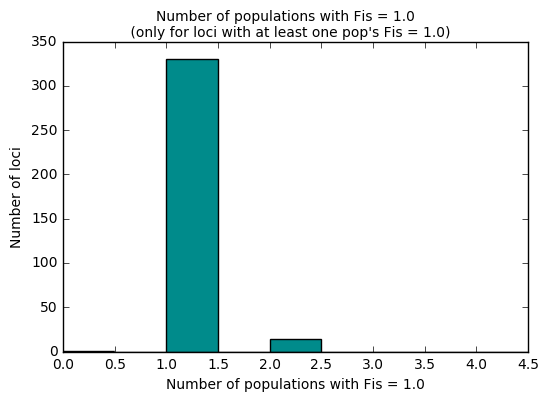

In [102]:
plt.hist(n_pops_fis1, bins = np.arange(0,5,0.5), color = "darkcyan")
plt.suptitle("Number of populations with Fis = 1.0 \n (only for loci with at least one pop's Fis = 1.0)")
plt.xlabel("Number of populations with Fis = 1.0")
plt.ylabel("Number of loci")
plt.show()


In [103]:
plt.close()

it almost looks like one of those loci has zero populations with Fis = 1.0...

In [106]:
x = 0
for count in n_pops_fis1:
    if count == float(0):
        x += 1
print "There are ", x, " loci erroneously included in the dictionary"

There are  0  loci erroneously included in the dictionary




<br>
<br>

### FOUR: Make sure that the "bad" loci that are out of HWE were correctly filtered out of the genepop file**

Some loci that are in my file: `batch_6.filteredMAF_filteredLoci_30filteredIndivids_BADhwe.txt`: 10006, 10062, 9994, 998

None of these are in my base file, `batch_6.filteredMAF_filteredLoci_30filteredIndivids_filteredHWE.gen`, or in the file I put into genepop: `batch_6_filteredMAF_filteredLoci_30filteredIndivids_filteredHWE.txt`, or in the parsed genepop file, `batch_6_30_INFgenepop_parsed_output.txt`